# Unadjusted Langevin Primal-Dual Algorithm (ULPDA) for TV-$\ell^2$ regularization

In [2]:
# Copied from TP5
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
print(torch.__version__)

pi = torch.pi

def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    mse = np.sqrt(np.mean((np.array(uref)-np.array(ut))**2))
    return 20*np.log10(M/mse)

def optim(f,niter=1000,lr=0.1):
    u = torch.randn(M,N, requires_grad=True)
    optimu = torch.optim.SGD([u], lr=lr)
    losslist = []
    for it in tqdm(range(niter)):
        loss = f(u)
        losslist.append(loss.detach())
        optimu.zero_grad()
        loss.backward()
        optimu.step()
    return u.detach(),losslist

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,z=2,order=0,titre='',displayfilename=False):
    imin= np.array(im).copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()

2.1.2+cpu


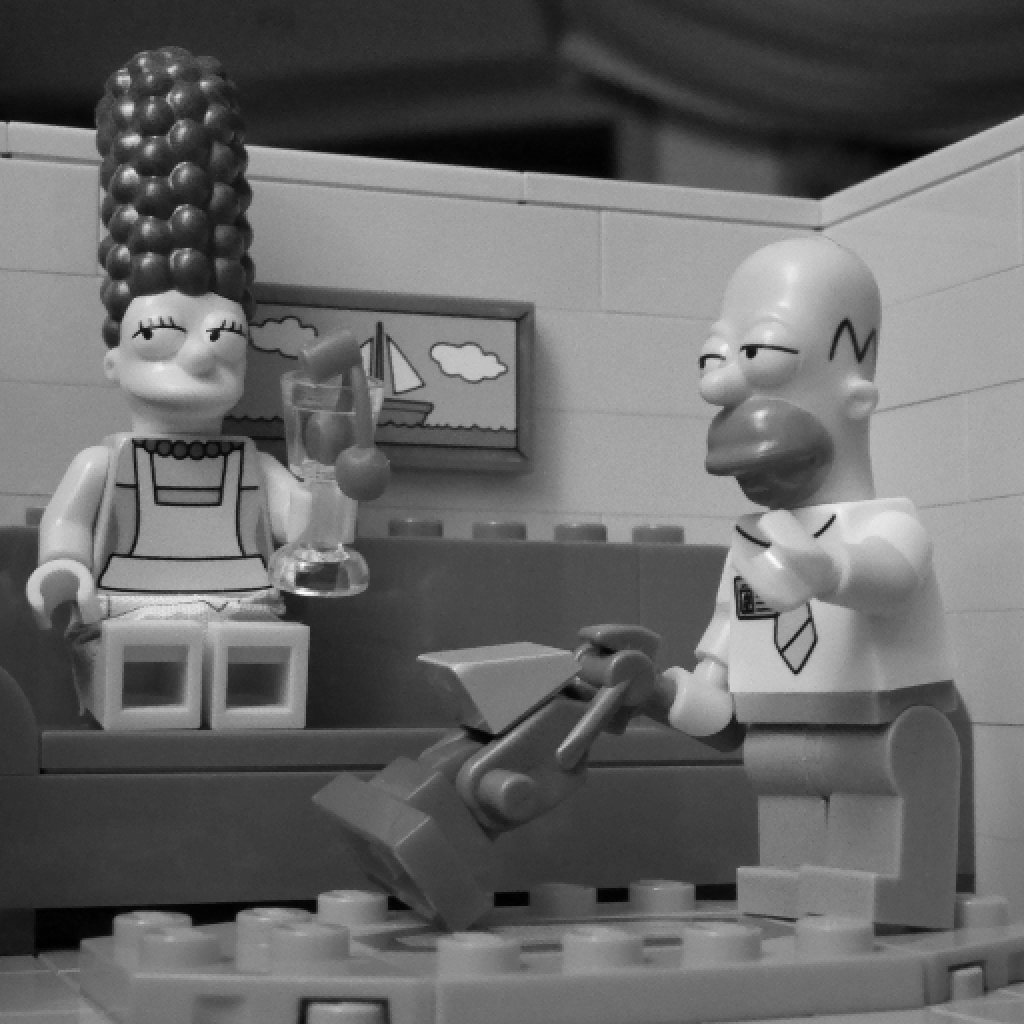

In [3]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512.png')))
M,N = u0.shape

viewimage(u0)

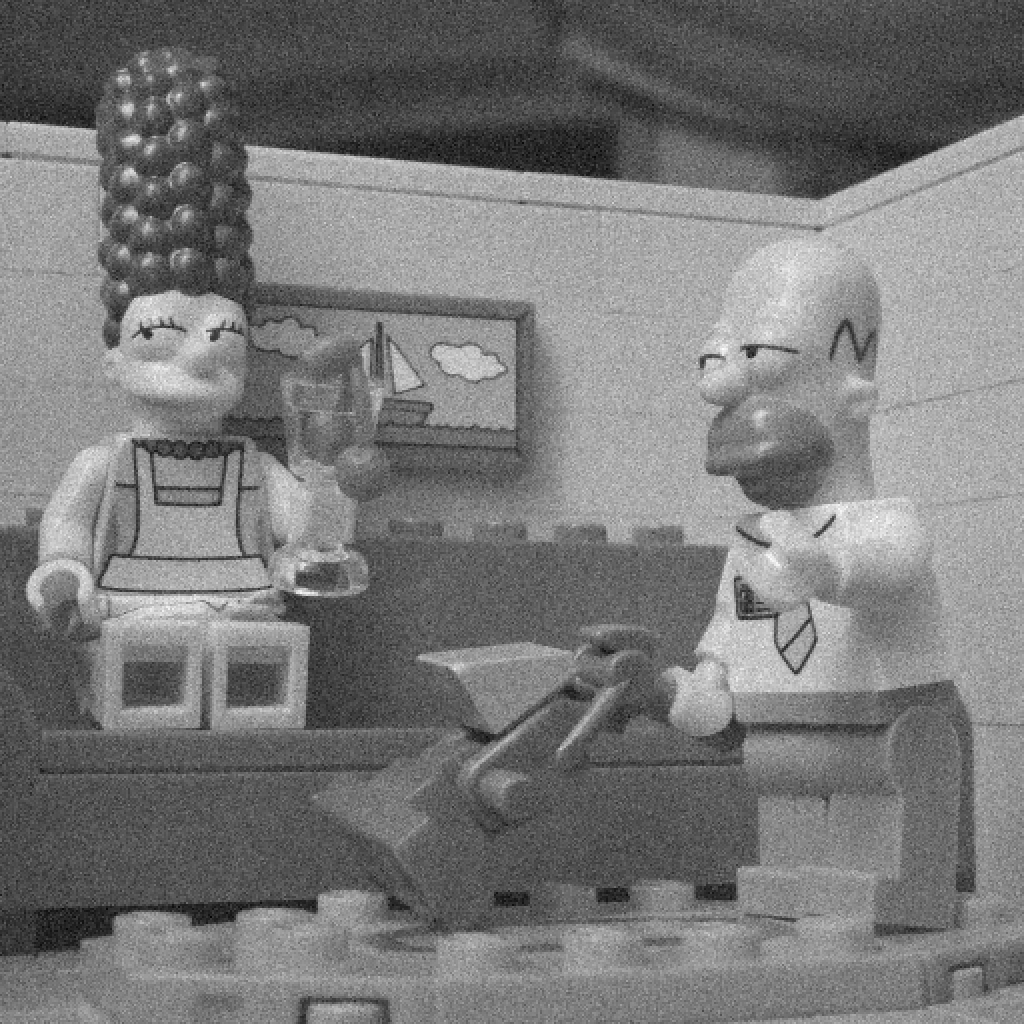

In [6]:
sigma = .05
z = u0 + sigma*torch.randn((M, N))

viewimage(z)

In [ ]:
def Dstar(pbar_k):
    ret = torch.zeros((M, N), dtype=torch.double)
    ret[1:] += pbar_k[:-1, :, 0]
    ret[:-1] -= pbar_k[:-1, :, 0]
    ret[:, 1:] += pbar_k[:, 1:, 1]
    ret[:, :-1] -= pbar_k[:, :-1, 1]
    return ret

def D(x):
    ret = torch.zeros((M, N, 2), dtype=torch.double)
    ret[:-1] = x[1:] - x[:-1]
    ret[:, :-1] = x[:, 1:] - x[:, :-1]
    return ret

def prox_tauk_g(v, sigma, tau_k):
    return 1/(1+tau_k/sigma**2)*(tau_k/sigma**2*z + v)

def prox_sigmak_fstar(v, s_k):
    return torch.minimum(torch.tensor(1.0, dtype=v.dtype), torch.maximum(torch.tensor(-1.0, dtype=v.dtype), v))

def ulpda(x0, p0, sigma, s_k, tau_k, theta_k, K=1000):
    """
    Unadjusted Langevin primal-dual algorithm for TV-l2 regularisation.

    Parameters
    ----------
    x0 : (M, N) numpy.ndarray
        Initial image sample.
    p0 : (M, N, 2) numpy.ndarray
        Initial auxiliary vector.
    sigma : float
        Standard deviation of the noise added to the image.
    s_k : float
        $\\sigma_k$.
    tau_k : float
        $\\tau_k$.
    theta_k : float
        $\\theta_k$.
    """
    x = x0.detach().clone()
    p = p0.detach().clone()
    p_prev = None
    x_list = [x]
    for k in range(K):
        pbar_k = p if k==0 else p + theta_k*(p-p_prev)
        v = x - tau_k*Dstar(pbar_k)
        xi_k = torch.randn((M, N))
        x = prox_tauk_g(v, sigma, tau_k) + (2*tau_k)**.5*xi_k
        x_list.append(x)
        p_prev = p
        p = prox_sigmak_fstar(p + s_k*D(x), s_k)
